In [1]:
%load_ext autoreload
%autoreload 2

## Logistic Regression
<center><img src="../../img/regression_logistic.png" width="700"></center>

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

sys.path.append('..')
from utils.preprocessing import load_dataframes

from constants import CATEGORIES
import pickle
import optuna
import numpy as np
from sklearn.metrics import recall_score, f1_score
from typing import Literal
from functools import partial
import shap


/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [3]:
import tiktoken

In [33]:
# from utils.tokenize_api import preprocess_text, gpt_tokenize
# from nltk.tokenize import word_tokenize
# params ={ 
#     "word_tokenize_no_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": False,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": False,
#         "is_lemmatization": False,
#         "remove_punctuations": False,
#     },
#     "gpt_tokenize_no_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": False,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": False,
#         "is_lemmatization": False,
#         "remove_punctuations": False,
#     },
#     "word_tokenize_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": True,
#         "is_replace_emojis": True,
#         "is_lowercase": True,
#         "is_lemmatization": True,
#         "remove_punctuations": False,
#     },
#     "gpt_tokenize_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": True,
#         "is_replace_emojis": True,
#         "is_lowercase": True,
#         "is_lemmatization": True,
#         "remove_punctuations": False,
#     },
#     "word_tokenize_full_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": True,
#         "is_replace_emojis": True,
#         "is_lowercase": True,
#         "is_lemmatization": True,
#         "remove_punctuations": True,
#     },
#     "gpt_tokenize_full_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": True,
#         "is_replace_emojis": True,
#         "is_lowercase": True,
#         "is_lemmatization": True,
#         "remove_punctuations": True,
#     },
#     "word_tokenize_simple_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#         "remove_punctuations": False,
#     },
#     "gpt_tokenize_simple_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#         "remove_punctuations": False,
#     },
# }

# (df_train, df_val, df_test) = load_dataframes()
# for tn, p in params.items():
#     print(f"Processing {tn}")
#     df_train[f'comment_text_{tn}'] = df_train['comment_text'].apply(lambda x: preprocess_text(x, **p))
#     df_val[f'comment_text_{tn}'] = df_val['comment_text'].apply(lambda x: preprocess_text(x, **p))
#     df_test[f'comment_text_{tn}'] = df_test['comment_text'].apply(lambda x: preprocess_text(x, **p))

# df_train.rename(columns={'comment_text': 'comment_text_baseline'}, inplace=True)
# df_val.rename(columns={'comment_text': 'comment_text_baseline'}, inplace=True)
# df_test.rename(columns={'comment_text': 'comment_text_baseline'}, inplace=True)

# df_train.to_parquet('data/df_train_preprocessed.parquet')
# df_val.to_parquet('data/df_val_preprocessed.parquet')
# df_test.to_parquet('data/df_test_preprocessed.parquet')

Processing word_tokenize_no_normalization
Processing gpt_tokenize_no_normalization
Processing word_tokenize_normalization
Processing gpt_tokenize_normalization
Processing word_tokenize_full_normalization
Processing gpt_tokenize_full_normalization
Processing word_tokenize_simple_normalization
Processing gpt_tokenize_simple_normalization


### Load parquet

In [4]:
df_train = pd.read_parquet('data/df_train_preprocessed.parquet')
df_val = pd.read_parquet('data/df_val_preprocessed.parquet')
df_test = pd.read_parquet('data/df_test_preprocessed.parquet')

In [5]:
preprocess_types = [
    "baseline",
    "word_tokenize_no_normalization",
    "gpt_tokenize_no_normalization",
    "word_tokenize_normalization",
    "gpt_tokenize_normalization",
    "word_tokenize_simple_normalization",
    "gpt_tokenize_simple_normalization",
    "word_tokenize_full_normalization",
    "gpt_tokenize_full_normalization"
]

In [269]:
y_train = df_train['overall_toxic']
y_valid = df_val['overall_toxic']
y_test = df_test['overall_toxic']

# Binary Classification

## TF-IDF

### Vectorize

In [7]:
def tfidf_vectorize_and_split(preprocess_type: str) -> tuple:
    vectorizer = TfidfVectorizer(tokenizer=str.split)
    X_train = vectorizer.fit_transform(df_train[f"comment_text_{preprocess_type}"])
    X_valid = vectorizer.transform(df_val[f"comment_text_{preprocess_type}"])
    X_test = vectorizer.transform(df_test[f"comment_text_{preprocess_type}"])
    return (X_train, X_valid, X_test, vectorizer)

In [8]:
# Xs = {preprocess_type: tfidf_vectorize_and_split(preprocess_type) for preprocess_type in preprocess_types}
# with open('data/Xs_tf_idf.pickle', 'wb') as file:
#     pickle.dump(Xs, file, protocol=pickle.HIGHEST_PROTOCOL)

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
with open('data/Xs_tf_idf.pickle', 'rb') as file:
    Xs = pickle.load(file)

### Train 

In [270]:
def logistic_regression_from_preprocess(Xs, preprocess_type:str  ,is_val = True , model=None, logistic_regression_args={}, ):
    X_train, X_val, X_test, _ = Xs[preprocess_type] 
    if model is None:
        model = LogisticRegression(**logistic_regression_args)
        model.fit(X_train, y_train)
    if is_val:
        y_pred = model.predict(X_val)
        return model, y_valid, y_pred
    if not is_val:
        y_pred = model.predict(X_test)
        return model, y_test, y_pred

In [9]:
def get_macro_results(results):
    macro_results = {}
    for preprocess_type, (_, y_true, y_pred) in results.items():
        report = classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic'], output_dict=True)
        macro_results[preprocess_type] = report['macro avg']
    return macro_results


In [237]:
def get_weight_results(results):
    macro_results = {}
    for preprocess_type, (_, y_true, y_pred) in results.items():
        print(preprocess_type)
        report = classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic'], output_dict=True)
        print(report)
        macro_results[preprocess_type] = report['macro avg']
    return macro_results

In [12]:
def print_results(results):
    for preprocess_type, (_, y_true, y_pred) in results.items():
        print(preprocess_type)
        print(classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic']))

In [13]:
logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=True, logistic_regression_args={"class_weight": "balanced", "max_iter": 1000 }) for preprocess_type in preprocess_types}

### Macro Val Results

In [14]:
macro_val_results = get_macro_results(logistic_regression_val_results)

#### F1 Sorted

In [15]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'gpt_tokenize_simple_normalization': {'precision': 0.820224002373932,
  'recall': 0.9117962471993488,
  'f1-score': 0.8578723710573393,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.816390526024743,
  'recall': 0.9090775398660452,
  'f1-score': 0.8542961787335945,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.8148545827385689,
  'recall': 0.9019757329430731,
  'f1-score': 0.8508804959853382,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.813442776665185,
  'recall': 0.904875487809079,
  'f1-score': 0.8508541971770835,
  'support': 31915.0},
 'gpt_tokenize_full_normalization': {'precision': 0.

Best is word_tokenize_simple_normalization with a f1 score of 0.854, baseline is 0.8318

#### Recall Sorted

In [16]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'gpt_tokenize_simple_normalization': {'precision': 0.820224002373932,
  'recall': 0.9117962471993488,
  'f1-score': 0.8578723710573393,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.816390526024743,
  'recall': 0.9090775398660452,
  'f1-score': 0.8542961787335945,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.813442776665185,
  'recall': 0.904875487809079,
  'f1-score': 0.8508541971770835,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.8113359162970009,
  'recall': 0.9033954707302511,
  'f1-score': 0.8488896391064442,
  'support': 31915.0},
 'gpt_tokenize_full_normalization': {'precision': 0.81390

Best is word_tokenize_no_normalization with a recall score of 0.91 , baseline is 0.89

### Optuna – Search Best Hyperparameters

In [117]:
X_train, X_val, X_test, _ = Xs["gpt_tokenize_simple_normalization"]

In [118]:
def objective(metric: Literal["recall_score", "f1_score"], trial):
    # Load data
    # Suggest values for the hyperparameters

    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 1, 50, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_val)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [119]:
objective_recall = partial(objective, "recall_score")
objective_f1_score = partial(objective, "f1_score")

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_recall, n_trials=50)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-05-12 21:04:47,344] A new study created in memory with name: no-name-042553b6-3e38-4e51-918d-206ca42726b9
[I 2024-05-12 21:04:51,840] Trial 0 finished with value: 0.9159577761759209 and parameters: {'penalty': 'l1', 'C': 0.6789978427526435}. Best is trial 0 with value: 0.9159577761759209.
[I 2024-05-12 21:04:58,327] Trial 1 finished with value: 0.910363198832832 and parameters: {'penalty': 'l1', 'C': 2.3656027658678953}. Best is trial 0 with value: 0.9159577761759209.
[I 2024-05-12 21:04:59,238] Trial 2 finished with value: 0.7025297809697937 and parameters: {'penalty': 'l1', 'C': 0.0031202705305512068}. Best is trial 0 with value: 0.9159577761759209.
[I 2024-05-12 21:05:00,919] Trial 3 finished with value: 0.9135165804446472 and parameters: {'penalty': 'l2', 'C': 1.997854669418872}. Best is trial 0 with value: 0.9159577761759209.
[I 2024-05-12 21:05:02,321] Trial 4 finished with value: 0.8609882928831494 and parameters: {'penalty': 'l2', 'C': 0.018602975936080325}. Best is tri

Best trial:
  Value: 0.9163909344676098
  Params: 
    penalty: l1
    C: 0.7689145660077934


None F1: 0.8729009188900303

In [38]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_f1_score, n_trials=50)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-05-12 21:13:13,304] A new study created in memory with name: no-name-a554706c-aba4-44ce-8c16-b7003575fe3e
[I 2024-05-12 21:13:15,662] Trial 0 finished with value: 0.8731073740914231 and parameters: {'penalty': 'l2', 'C': 30.331584666041206}. Best is trial 0 with value: 0.8731073740914231.
[I 2024-05-12 21:13:17,929] Trial 1 finished with value: 0.872398857038325 and parameters: {'penalty': 'l2', 'C': 17.22817749092859}. Best is trial 0 with value: 0.8731073740914231.
[I 2024-05-12 21:13:43,104] Trial 2 finished with value: 0.8514033229104874 and parameters: {'penalty': 'l1', 'C': 31.987136239207466}. Best is trial 0 with value: 0.8731073740914231.
[I 2024-05-12 21:13:57,189] Trial 3 finished with value: 0.8610551593876643 and parameters: {'penalty': 'l1', 'C': 12.820229510020386}. Best is trial 0 with value: 0.8731073740914231.
[I 2024-05-12 21:14:16,557] Trial 4 finished with value: 0.8541046005615823 and parameters: {'penalty': 'l1', 'C': 22.64813576322309}. Best is trial 0 w

Best trial:
  Value: 0.8738400590235452
  Params: 
    penalty: l2
    C: 9.686026200754604


#### Best Model on Macro Recall
Best trial:
  Value: 0.9163909344676098
  Params: 
    penalty: l1
    C: 0.7689145660077934

In [17]:
best_recall_logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=True, logistic_regression_args={"penalty": "l1", "C": .7689145660077934, "solver": "liblinear", "class_weight": "balanced"}) for preprocess_type in preprocess_types}

In [18]:
best_recall_macro_val_results = get_macro_results(best_recall_logistic_regression_val_results)
best_recall_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_recall_macro_val_result_sorted


{'gpt_tokenize_simple_normalization': {'precision': 0.8230440842352525,
  'recall': 0.9163909344676098,
  'f1-score': 0.8613553173759991,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.8221676508669911,
  'recall': 0.9136514602651682,
  'f1-score': 0.8598399930093885,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8169159947779923,
  'recall': 0.9117298179469702,
  'f1-score': 0.8555270586033952,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.8182244560087498,
  'recall': 0.9110520051860942,
  'f1-score': 0.8562288207022337,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.8092626851588164,
  'recall': 0.9072318044057889,
  'f1-score': 0.8486328924757447,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.8101254323427324,
  'recall': 0.9050650022894626,
  'f1-score': 0.8485673651752353,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.

#### Best Model on Macro F1
  Value: 0.8738400590235452
  Params: 
    penalty: l2
    C: 9.686026200754604

In [19]:
best_f1_logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=True, logistic_regression_args={"penalty": "l2", "C": 9.686026200754604, "class_weight": "balanced", "max_iter": 1000}) for preprocess_type in preprocess_types}

In [20]:
best_f1_macro_val_results = get_macro_results(best_f1_logistic_regression_val_results)
best_f1_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
best_f1_macro_val_result_sorted

{'gpt_tokenize_simple_normalization': {'precision': 0.8230440842352525,
  'recall': 0.9163909344676098,
  'f1-score': 0.8613553173759991,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.8221676508669911,
  'recall': 0.9136514602651682,
  'f1-score': 0.8598399930093885,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.8182244560087498,
  'recall': 0.9110520051860942,
  'f1-score': 0.8562288207022337,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8169159947779923,
  'recall': 0.9117298179469702,
  'f1-score': 0.8555270586033952,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.8152028374461138,
  'recall': 0.9048665155324569,
  'f1-score': 0.852082968495943,
  'support': 31915.0},
 'gpt_tokenize_full_normalization': {'precision': 0.8115416744475568,
  'recall': 0.9035844798816937,
  'f1-score': 0.8490960557695992,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision':

### Final Test set

In [271]:
best_f1_logistic_regression_test_results = {preprocess_type: logistic_regression_from_preprocess(Xs, preprocess_type, is_val=False, logistic_regression_args={"penalty": "l1", "C": .7689145660077934, "solver": "liblinear", "class_weight": "balanced", "max_iter": 1000}) for preprocess_type in preprocess_types}

#### Macro Test Results

In [272]:
best_f1_macro_test_results = get_macro_results(best_f1_logistic_regression_test_results)

In [273]:
best_f1_macro_test_results = get_weight_results(best_f1_logistic_regression_test_results)

baseline
{'non-toxic': {'precision': 0.9850065189048239, 'recall': 0.8636528968563263, 'f1-score': 0.920346631966555, 'support': 57735.0}, 'toxic': {'precision': 0.4106019766397125, 'recall': 0.8784238346948583, 'f1-score': 0.5596203887953467, 'support': 6243.0}, 'accuracy': 0.8650942511488324, 'macro avg': {'precision': 0.6978042477722682, 'recall': 0.8710383657755922, 'f1-score': 0.7399835103809509, 'support': 63978.0}, 'weighted avg': {'precision': 0.9289558834151074, 'recall': 0.8650942511488324, 'f1-score': 0.8851468142773828, 'support': 63978.0}}
word_tokenize_no_normalization
{'non-toxic': {'precision': 0.9919771004676665, 'recall': 0.8523425998094744, 'f1-score': 0.9168739461352859, 'support': 57735.0}, 'toxic': {'precision': 0.406750173973556, 'recall': 0.9362485984302419, 'f1-score': 0.5671178382574104, 'support': 6243.0}, 'accuracy': 0.8605301822501484, 'macro avg': {'precision': 0.6993636372206112, 'recall': 0.8942955991198581, 'f1-score': 0.7419958921963481, 'support': 639

##### F1 Sorted

In [274]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
best_f1_macro_test_result_sorted

{'gpt_tokenize_no_normalization': {'precision': 0.7082618860245806,
  'recall': 0.8928663485800901,
  'f1-score': 0.7533654785511354,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7054105271390178,
  'recall': 0.8952446402220422,
  'f1-score': 0.7498532181735105,
  'support': 63978.0},
 'gpt_tokenize_full_normalization': {'precision': 0.7004263925864239,
  'recall': 0.8891314177308567,
  'f1-score': 0.7434656354267999,
  'support': 63978.0},
 'word_tokenize_simple_normalization': {'precision': 0.7004269073324936,
  'recall': 0.8941377793375398,
  'f1-score': 0.7434111309950837,
  'support': 63978.0},
 'word_tokenize_full_normalization': {'precision': 0.699519530236319,
  'recall': 0.8930986898623419,
  'f1-score': 0.7422292104280755,
  'support': 63978.0},
 'word_tokenize_no_normalization': {'precision': 0.6993636372206112,
  'recall': 0.8942955991198581,
  'f1-score': 0.7419958921963481,
  'support': 63978.0},
 'gpt_tokenize_normalization': {'precision':

Best is word_tokenize_simple_normalization with a f1 score of 0.854, baseline is 0.8318

##### Recall Sorted

In [235]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_test_result_sorted

{'gpt_tokenize_full_normalization': {'precision': 0.5732537657880881,
  'recall': 0.9253479200061238,
  'f1-score': 0.618486737707361,
  'support': 63978.0},
 'word_tokenize_normalization': {'precision': 0.555838756758694,
  'recall': 0.9251931346852464,
  'f1-score': 0.589232841224253,
  'support': 63978.0},
 'gpt_tokenize_normalization': {'precision': 0.5633709943824994,
  'recall': 0.9213680503650488,
  'f1-score': 0.602311677223701,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.5695237874102832,
  'recall': 0.9178678074675362,
  'f1-score': 0.6124090956069009,
  'support': 63978.0},
 'word_tokenize_full_normalization': {'precision': 0.5670411487455964,
  'recall': 0.9159001684155101,
  'f1-score': 0.6083567012657959,
  'support': 63978.0},
 'word_tokenize_simple_normalization': {'precision': 0.5558509352526028,
  'recall': 0.9109299040313876,
  'f1-score': 0.5893377064333247,
  'support': 63978.0},
 'word_tokenize_no_normalization': {'precision': 0.55

### Interpretation

#### Prepare 

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


In [13]:
enc = tiktoken.encoding_for_model("gpt-4")

In [36]:
best_preprocess = "gpt_tokenize_full_normalization"
X_train, X_val, X_test, vectorizer = Xs[best_preprocess]
best_model, y_test, y_pred = best_f1_logistic_regression_test_results[best_preprocess]
vec = Xs[best_preprocess][3]

In [37]:
# test =Xs[best_preprocess][2]
false_negatives = df_test[(y_pred == 0) & (y_test == 1)]
false_positives = df_test[(y_pred == 1) & (y_test == 0)]

In [38]:
def show_word_cloud(comments):
    comments = ' '.join(comments)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comments)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [39]:
comments_train = df_train[f"comment_text_{best_preprocess}"].str.cat(sep=" ")
comments_train = enc.decode([ int(c) for c in comments_train.split()])
counter_train = Counter(comments_train.split())

#### False Positives Word Cloud

In [80]:
comments_false_positives = false_positives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
comments_false_positives = enc.decode([ int(c) for c in comments_false_positives.split()])
comments_false_positives = comments_false_positives.split()

In [91]:
comments_false_positives = false_positives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
comments_false_positives = enc.decode([ int(c) for c in comments_false_positives.split()])

In [175]:
com = false_positives[false_positives[f"comment_text_{best_preprocess}"].apply(len) < 100]["comment_text_baseline"]

In [176]:
com

1                         :Dear god this site is horrible.
12       . \n\n           Jews are not a race because y...
27       I WILL BURN YOU TO HELL IF YOU REVOKE MY TALK ...
61       == black mamba == \n\n It.is ponious snake of ...
79                             WHAT THE HELL \n\n   Justin
                               ...                        
63942    Bill clinton is al-qaeda, its all about gettin...
63950                      The Yatt got me, this is insane
63972    shut down the mexican border withought looking...
63974    ==Lucky bastard== \n http://wikimediafoundatio...
63975    ==shame on you all!!!== \n\n You want to speak...
Name: comment_text_baseline, Length: 4266, dtype: object

In [179]:
com.iloc[41]

'* Block evading IP sockpuppet;'

In [229]:
best_model.predict(vec.transform([" ".join([str(e) for e in enc.encode('good hero please please please stupid  beceause you are not so good article thank you very much talk to the source')])]))

array([1])

In [41]:
Counter(comments_false_positives).most_common(20)

[('like', 1890),
 ('get', 1576),
 ('dont', 1531),
 ('article', 1525),
 ('gay', 1508),
 ('people', 1506),
 ('say', 1460),
 ('go', 1390),
 ('make', 1364),
 ('page', 1334),
 ('one', 1320),
 ('know', 1217),
 ('im', 1195),
 ('think', 1186),
 ('would', 999),
 ('u', 890),
 ('see', 883),
 ('time', 870),
 ('use', 817),
 ('good', 772)]

In [42]:
counter_train.get("fuck")

7082

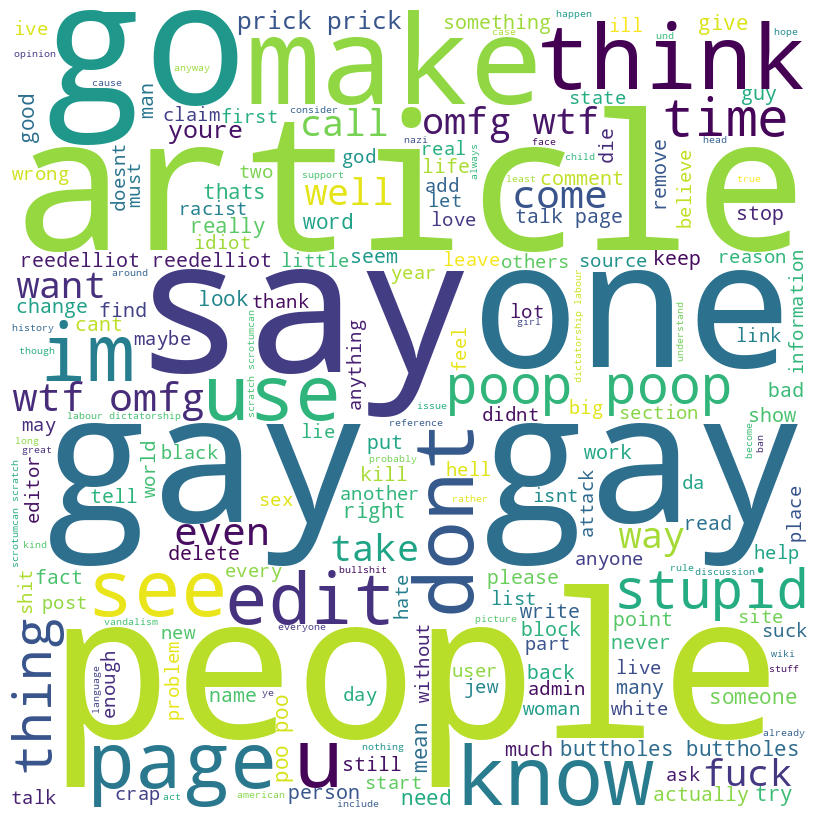

In [43]:
show_word_cloud(comments_false_positives)

#### False Negatives Word Cloud

In [53]:
comments_false_negatives = false_negatives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
comments_false_negatives = enc.decode([ int(c) for c in comments_false_negatives.split()])
comments_false_negatives = comments_false_negatives.split()

In [89]:
comments_false_negatives = false_negatives[f"comment_text_{best_preprocess}"].str.cat(sep = " ")
comments_false_negatives = enc.decode([ int(c) for c in comments_false_negatives.split()])

In [90]:
com = false_negatives[false_negatives[f"comment_text_{best_preprocess}"].apply(len) < 370]["comment_text_word_tokenize_full_normalization"]

In [79]:
com.iloc[22]

'nothing mos give support bizarre wording try enforce even try explain think say x describe random population segment best know z somehow good say x z motivation appear mixture stupidity spite'

In [ ]:
Counter(comments_false_negatives).most_common(50)

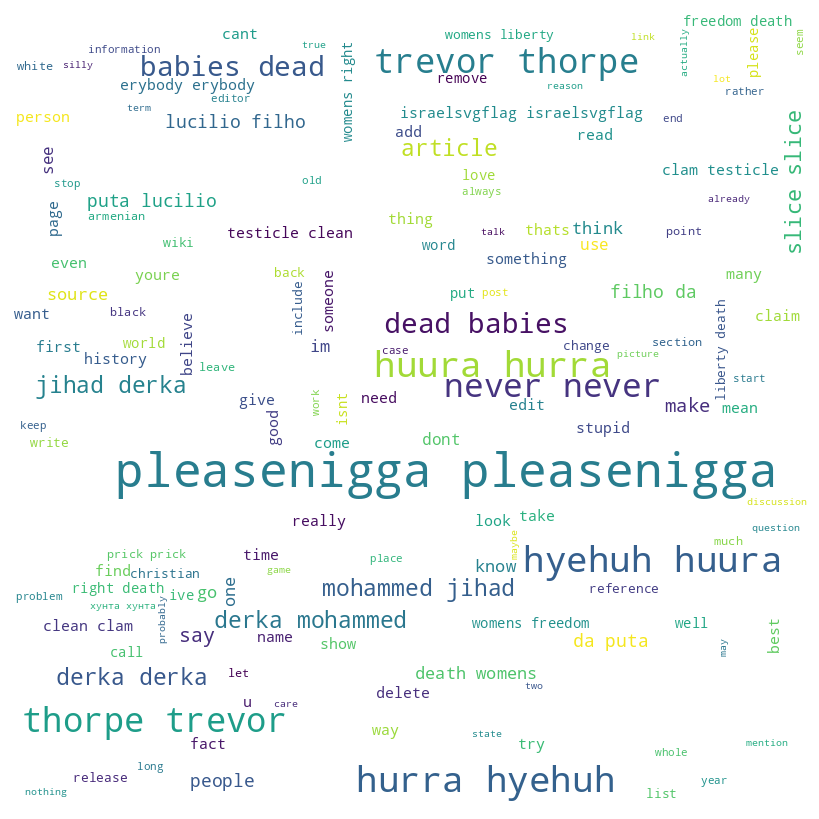

In [54]:
show_word_cloud(comments_false_negatives)

#### View Shap

In [98]:
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(best_model, masker)

In [99]:
# Convert csr_matrix to pandas DataFrame
X_train_df = pd.DataFrame(X_train.toarray())

# Select a random subset of your data
subset = X_train_df.sample(n=1000, random_state=0)

In [100]:
shap_values = explainer.shap_values(subset)

In [101]:
features_names=  [enc.decode([int(t)]) for t in  vectorizer.get_feature_names_out()]

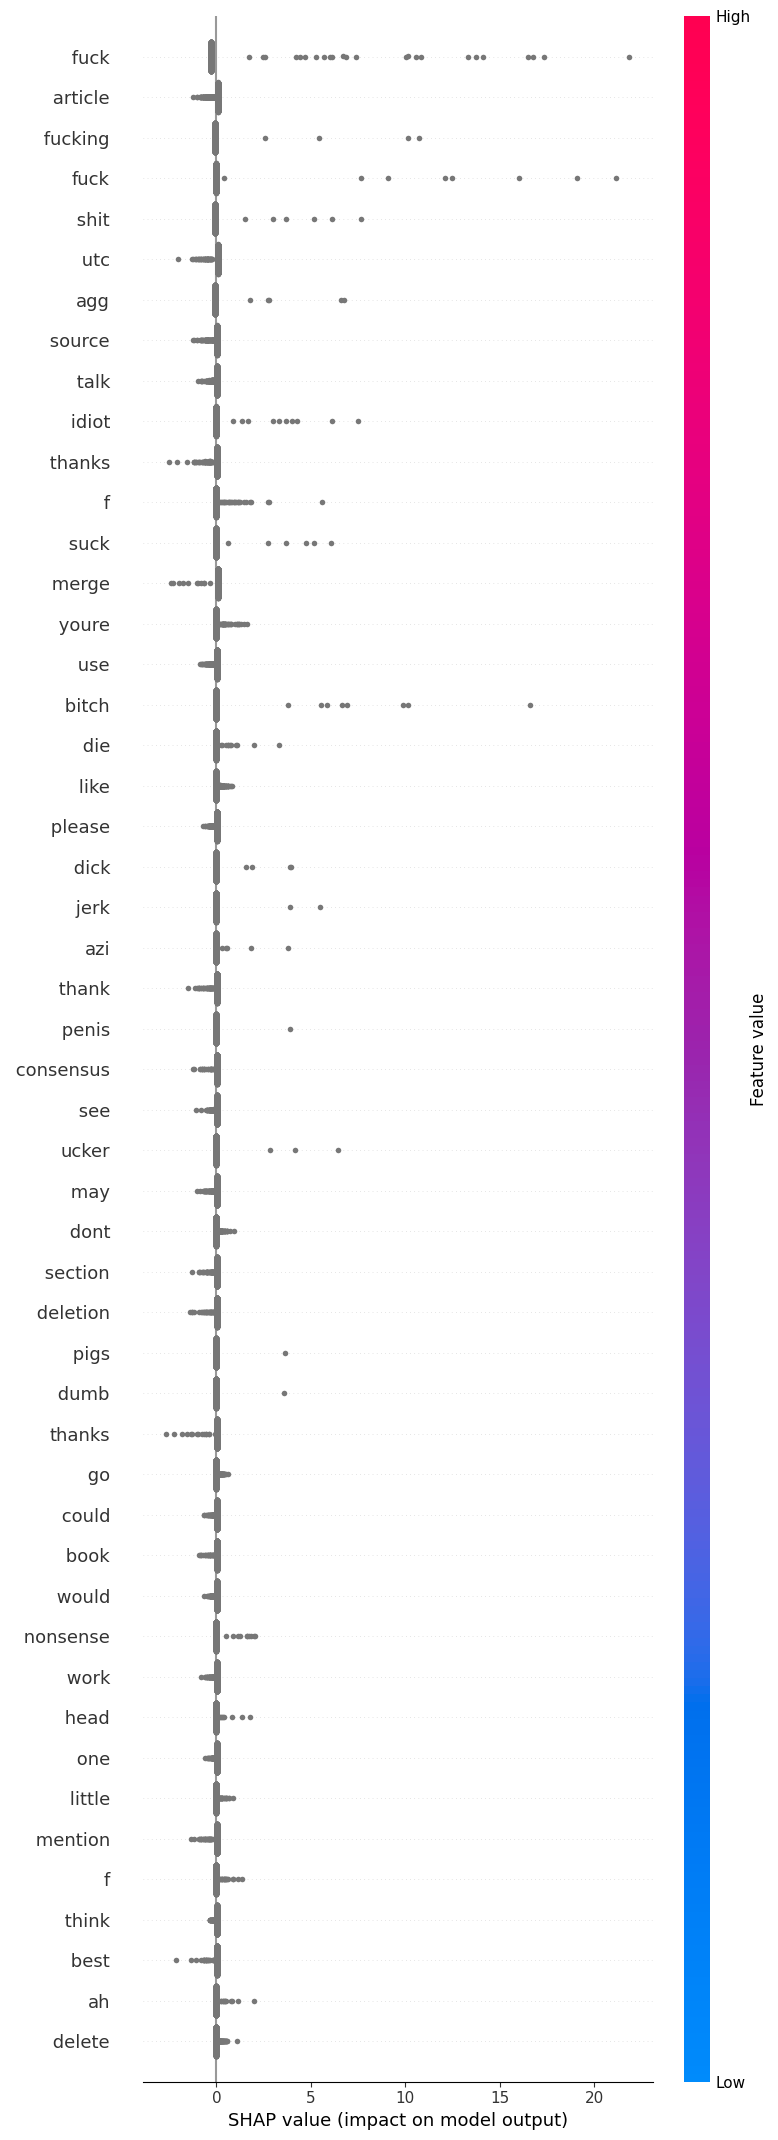

In [103]:
shap.summary_plot(shap_values, X_train, feature_names=features_names, max_display=50)

## Word to Vec

In [6]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import gensim.downloader

In [7]:
def itemget(model_vector, nb_feature: int, item:str):
    try:
        return model_vector[item]
    except:
        return np.zeros(nb_feature)

In [8]:
def mean(list_vectors, nb_feature: int) -> np.ndarray:
    if len(list_vectors) == 0:
        return np.zeros(nb_feature)
    return np.mean(list_vectors, axis=0)

In [9]:
def w2v_vectorize_and_split(model_vector, nb_feature,preprocess_type: str) -> tuple:
    X_train = df_train[f"comment_text_{preprocess_type}"].apply(lambda x: mean([itemget(model_vector,nb_feature,word) for word in x.split()], nb_feature))
    X_valid = df_val[f"comment_text_{preprocess_type}"].apply(lambda x: mean([itemget(model_vector,nb_feature,word)  for word in x.split()], nb_feature))
    X_test = df_test[f"comment_text_{preprocess_type}"].apply(lambda x: mean([itemget(model_vector,nb_feature,word)  for word in x.split()], nb_feature))
    return (np.vstack(X_train.to_numpy()), np.vstack(X_valid.to_numpy()), np.vstack(X_test.to_numpy()), model_vector)

### PreTrained

In [10]:
preprocess_types = [
    "baseline",
    "word_tokenize_no_normalization",
    "word_tokenize_normalization",
    "word_tokenize_simple_normalization",
    "word_tokenize_full_normalization",
]

In [ ]:
# print(list(gensim.downloader.info()['models'].keys()))

In [10]:
# glove_vectors = gensim.downloader.load('glove-twitter-200')
# Xs_w2v_pre_trained = {preprocess_type: w2v_vectorize_and_split(glove_vectors,200, preprocess_type) for preprocess_type in preprocess_types}
# with open('data/Xs_w2v_pre_trained.pickle', 'wb') as file:
#     pickle.dump(Xs_w2v_pre_trained, file, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('data/Xs_w2v_pre_trained.pickle', 'rb') as file:
    Xs_w2v_pre_trained = pickle.load(file)

In [ ]:
logistic_regression_val_results_w2v_pre = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_pre_trained,preprocess_type, is_val=True) for preprocess_type in preprocess_types}

#### Macro Val Results

In [ ]:
macro_val_results = get_macro_results(logistic_regression_val_results_w2v_pre)

##### F1 Sorted

In [22]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.7429903645763776,
  'recall': 0.8814677104913298,
  'f1-score': 0.7882206810522903,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.7391469124290759,
  'recall': 0.8768791731837973,
  'f1-score': 0.783826434427028,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.7382670895186385,
  'recall': 0.878732069262664,
  'f1-score': 0.783307201663809,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.7235214562892343,
  'recall': 0.8718081918853118,
  'f1-score': 0.7677573301745022,
  'support': 31915.0},
 'baseline': {'precision': 0.6817492429651377,
  'recall': 0.8371445349578175,
  'f1-score': 0.7181435687302702,
  'support': 31915.0}}

##### Recall Sorted

In [23]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.7429903645763776,
  'recall': 0.8814677104913298,
  'f1-score': 0.7882206810522903,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.7382670895186385,
  'recall': 0.878732069262664,
  'f1-score': 0.783307201663809,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.7391469124290759,
  'recall': 0.8768791731837973,
  'f1-score': 0.783826434427028,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.7235214562892343,
  'recall': 0.8718081918853118,
  'f1-score': 0.7677573301745022,
  'support': 31915.0},
 'baseline': {'precision': 0.6817492429651377,
  'recall': 0.8371445349578175,
  'f1-score': 0.7181435687302702,
  'support': 31915.0}}

#### Optuna – Search Best Hyperparameters

In [14]:
X_train, X_val, X_test, _ = Xs_w2v_pre_trained["word_tokenize_simple_normalization"]

In [32]:
def objective(metric: Literal["recall_score", "f1_score"], trial):
    penalty = trial.suggest_categorical("penalty", ["l2", None])
    C = trial.suggest_float("C", 1e-5, 10, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_val)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [33]:
objective_recall = partial(objective, "recall_score")
objective_f1_score = partial(objective, "f1_score")

In [34]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_recall, n_trials=10)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-05-12 01:27:35,873] A new study created in memory with name: no-name-b2023c65-72c0-4c13-bb61-d3cd9a45720c
[I 2024-05-12 01:27:38,658] Trial 0 finished with value: 0.8783586849336842 and parameters: {'penalty': 'l2', 'C': 0.0327991394653092}. Best is trial 0 with value: 0.8783586849336842.
[I 2024-05-12 01:27:40,210] Trial 1 finished with value: 0.8656337818374973 and parameters: {'penalty': 'l2', 'C': 0.0032827356778700662}. Best is trial 0 with value: 0.8783586849336842.
[I 2024-05-12 01:27:41,460] Trial 2 finished with value: 0.8528396271730381 and parameters: {'penalty': 'l2', 'C': 0.0010596096799956084}. Best is trial 0 with value: 0.8783586849336842.
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-05-12 01:27:46,112] Trial 3 finished with value: 0.8810199352912313 and parameters: {'penalty': None

Best trial:
  Value: 0.8810199352912313
  Params: 
    penalty: None
    C: 1.238223525595681


In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_f1_score, n_trials=10)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-05-12 01:28:20,101] A new study created in memory with name: no-name-fdacd89c-81de-49c4-aaea-3f963261933c
[I 2024-05-12 01:28:25,173] Trial 0 finished with value: 0.7879411182294576 and parameters: {'penalty': 'l2', 'C': 0.9480789284256366}. Best is trial 0 with value: 0.7879411182294576.
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-05-12 01:28:29,314] Trial 1 finished with value: 0.7876822673103441 and parameters: {'penalty': None, 'C': 4.36587169917872e-05}. Best is trial 0 with value: 0.7879411182294576.
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-05-12 01:28:33,630] Trial 2 finished with value: 0.7876822673103441 

Best trial:
  Value: 0.788683992598959
  Params: 
    penalty: l2
    C: 0.09392679408091835


##### Best Model on Macro Recall and F1 score
    No penalty

In [36]:
best_recall_logistic_regression_val_results_w2v_pre = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_pre_trained, preprocess_type, is_val=True, logistic_regression_args={"penalty": None }) for preprocess_type in preprocess_types}

In [37]:
best_recall_macro_val_results = get_macro_results(best_recall_logistic_regression_val_results_w2v_pre)
best_recall_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_recall_macro_val_result_sorted, best_f1_macro_val_result_sorted


({'word_tokenize_simple_normalization': {'precision': 0.7424974818722102,
   'recall': 0.8810199352912313,
   'f1-score': 0.7876822673103441,
   'support': 31915.0},
  'word_tokenize_full_normalization': {'precision': 0.7380900836935127,
   'recall': 0.8786623123654508,
   'f1-score': 0.7831273014499496,
   'support': 31915.0},
  'word_tokenize_normalization': {'precision': 0.7388962676922333,
   'recall': 0.8769112293165101,
   'f1-score': 0.7835963407587945,
   'support': 31915.0},
  'word_tokenize_no_normalization': {'precision': 0.723305624840908,
   'recall': 0.8712091082982711,
   'f1-score': 0.7674618779297886,
   'support': 31915.0},
  'baseline': {'precision': 0.6824184547662465,
   'recall': 0.8382437114178666,
   'f1-score': 0.7189916028296686,
   'support': 31915.0}},
 {'word_tokenize_simple_normalization': {'precision': 0.7424974818722102,
   'recall': 0.8810199352912313,
   'f1-score': 0.7876822673103441,
   'support': 31915.0},
  'word_tokenize_full_normalization': {'pre

#### Final Test set

In [38]:
best_f1_logistic_regression_test_results_w2v_pre = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_pre_trained, preprocess_type, is_val=False, logistic_regression_args={"penalty": None }) for preprocess_type in preprocess_types}

#### Macro Test Results

In [39]:
best_f1_macro_test_results = get_macro_results(best_f1_logistic_regression_test_results_w2v_pre)

##### F1 Sorted

In [41]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
best_recall_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_test_result_sorted, best_recall_macro_test_result_sorted


({'word_tokenize_simple_normalization': {'precision': 0.6791031535847579,
   'recall': 0.8607041767787977,
   'f1-score': 0.7155562360769496,
   'support': 63978.0},
  'word_tokenize_normalization': {'precision': 0.675757836742567,
   'recall': 0.8589849386834169,
   'f1-score': 0.710869667187221,
   'support': 63978.0},
  'word_tokenize_full_normalization': {'precision': 0.6709171760464523,
   'recall': 0.8643601998176643,
   'f1-score': 0.7029050681029787,
   'support': 63978.0},
  'word_tokenize_no_normalization': {'precision': 0.6620380237909484,
   'recall': 0.8375932730810756,
   'f1-score': 0.6923620883877397,
   'support': 63978.0},
  'baseline': {'precision': 0.6374647809792308,
   'recall': 0.8103565242226919,
   'f1-score': 0.6550992895330987,
   'support': 63978.0}},
 {'word_tokenize_full_normalization': {'precision': 0.6709171760464523,
   'recall': 0.8643601998176643,
   'f1-score': 0.7029050681029787,
   'support': 63978.0},
  'word_tokenize_simple_normalization': {'prec

### Scratch

In [68]:
VECTOR_SIZE = 200

In [69]:
model_vectors_scratch = []

In [78]:
preprocess_types = [
    "baseline",
    "word_tokenize_no_normalization",
    "gpt_tokenize_no_normalization",
    "word_tokenize_normalization",
    "gpt_tokenize_normalization",
    "word_tokenize_simple_normalization",
    "gpt_tokenize_simple_normalization",
    "word_tokenize_full_normalization",
    "gpt_tokenize_full_normalization"
]

In [79]:
for p in preprocess_types:
    model_vector = Word2Vec(sentences=df_train[f"comment_text_{p}"], min_count=1, window=10, workers=8, vector_size=VECTOR_SIZE)
    model_vector.save(f"data/word2vec_scratch_{p}.model")
    model_vectors_scratch.append(model_vector)

In [80]:
for p in preprocess_types:
    model_vector = Word2Vec.load(f"data/word2vec_scratch_{p}.model")
    model_vectors_scratch.append(model_vector)

In [81]:
Xs_w2v_scratch = {preprocess_type: w2v_vectorize_and_split(model.wv, VECTOR_SIZE, preprocess_type) for model, preprocess_type in zip(model_vectors_scratch, preprocess_types)} 
with open('data/Xs_w2v_scratch.pickle', 'wb') as file:
    pickle.dump(Xs_w2v_scratch, file, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
with open('data/Xs_w2v_scratch.pickle', 'rb') as file:
    Xs_w2v_scratch = pickle.load(file)

In [83]:
logistic_regression_val_results_w2v_scratch = {preprocess_type: logistic_regression_from_preprocess(Xs_w2v_scratch,preprocess_type, is_val=True) for preprocess_type in preprocess_types}

#### Macro Val Results

In [84]:
macro_val_results = get_macro_results(logistic_regression_val_results_w2v_scratch)

##### F1 Sorted

In [85]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'word_tokenize_no_normalization': {'precision': 0.5576670009145357,
  'recall': 0.6413963382617742,
  'f1-score': 0.5343953153061547,
  'support': 31915.0},
 'word_tokenize_full_normalization': {'precision': 0.5358789120248166,
  'recall': 0.5159850650139013,
  'f1-score': 0.5152857688157441,
  'support': 31915.0},
 'gpt_tokenize_full_normalization': {'precision': 0.5353650026804658,
  'recall': 0.5157116820568359,
  'f1-score': 0.5148966719975616,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.5577361097045873,
  'recall': 0.654482487040678,
  'f1-score': 0.5054874209010312,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.5577521137386148,
  'recall': 0.6548148429603228,
  'f1-score': 0.5043295152299618,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.5276613158012825,
  'recall': 0.5652824782329021,
  'f1-score': 0.501881238232184,
  'support': 31915.0},
 'baseline': {'precision': 0.5213712349558562,
  'r

Best is word_tokenize_simple_normalization with a f1 score of 0.854, baseline is 0.8318

##### Recall Sorted

In [86]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.5577521137386148,
  'recall': 0.6548148429603228,
  'f1-score': 0.5043295152299618,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.5577361097045873,
  'recall': 0.654482487040678,
  'f1-score': 0.5054874209010312,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.5576670009145357,
  'recall': 0.6413963382617742,
  'f1-score': 0.5343953153061547,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.538097955897253,
  'recall': 0.5980000327711195,
  'f1-score': 0.39170815458622854,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.5368614421280683,
  'recall': 0.5923009437265261,
  'f1-score': 0.37770475312976165,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.5276613158012825,
  'recall': 0.5652824782329021,
  'f1-score': 0.501881238232184,
  'support': 31915.0},
 'baseline': {'precision': 0.5213712349558562,
  'reca

Best is word_tokenize_no_normalization with a recall score of 0.91 , baseline is 0.89

# Multilabel Logistic Regression

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

## TF-IDF

In [ ]:
CATEGORIES += ["overall_toxic"]

In [ ]:
y_train = df_train[CATEGORIES]
y_val_cat = df_val[CATEGORIES]

### Best Macro Recall Model 

In [ ]:
classifier = OneVsRestClassifier(LogisticRegression(**best_model.get_params()))
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=2.233,
                                                 class_weight='balanced',
                                                 max_iter=1000))

In [ ]:
y_pred = classifier.predict(X_valid)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))
accuracy_score(y_val_cat, y_pred)

               precision    recall  f1-score   support

        toxic       0.67      0.84      0.75      3056
 severe_toxic       0.29      0.79      0.43       321
      obscene       0.73      0.88      0.80      1715
       threat       0.22      0.68      0.34        74
       insult       0.59      0.84      0.69      1614
identity_hate       0.30      0.71      0.42       294
overall_toxic       0.69      0.85      0.76      3244

    micro avg       0.62      0.84      0.72     10318
    macro avg       0.50      0.80      0.60     10318
 weighted avg       0.65      0.84      0.73     10318
  samples avg       0.07      0.08      0.07     10318



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to contr

0.8813410621964594

### Best Macro F1 Model 

In [ ]:
f1_classifier = OneVsRestClassifier(LogisticRegression(**best_model_f1.get_params()))
f1_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, penalty=None))

In [ ]:
y_pred = f1_classifier.predict(X_valid)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))
accuracy_score(y_val_cat, y_pred)

               precision    recall  f1-score   support

        toxic       0.72      0.76      0.74      3056
 severe_toxic       0.34      0.55      0.42       321
      obscene       0.78      0.76      0.77      1715
       threat       0.24      0.45      0.31        74
       insult       0.63      0.70      0.66      1614
identity_hate       0.37      0.57      0.45       294
overall_toxic       0.76      0.76      0.76      3244

    micro avg       0.69      0.74      0.71     10318
    macro avg       0.55      0.65      0.59     10318
 weighted avg       0.71      0.74      0.72     10318
  samples avg       0.07      0.07      0.07     10318



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to contr

0.8867617107942973

## Word to Vec